Notebook

## Model to predict the cell type based on the enhancer promoter contact and orientation data 

This notebook contains the model built to differenciate the normal and cancer cell line based on the orientation of the enhancer and promoter of the AR gene locus. 


In [8]:
# importing libraries

# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries to split data, impute missing values 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Libraries to import decision tree classifier and different ensemble classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [9]:
pwd

'/Users/kirankumari/Dropbox/UT_Austin/cancer_TADs/multiway_contact'

In [10]:
# Installing the libraries
# pip install xgboost

In [11]:
#Loading the dataset 
data_rwpe1=pd.read_csv("df_orient_rwpe1_ARlocus.csv", index_col=(0))
data_rwpe1['target'] = 0
data_c42b=pd.read_csv("df_orient_c42b_ARlocus.csv", index_col=(0))
data_c42b['target'] = 1
data_22rv1=pd.read_csv("df_orient_22rv1_ARlocus.csv", index_col=(0))
data_22rv1['target'] = 2

data = pd.concat([data_rwpe1, data_c42b, data_22rv1])

In [12]:
data.head()

,orient_e2,orient_e3,orient_e4,orient_e5,orient_e6,orient_e7,orient_e8,dist_e1,dist_e2,dist_e3,dist_e4,dist_e5,dist_e6,dist_e7,dist_e8,target
0,0.685435,0.796729,0.907707,0.971096,0.856117,0.720965,0.740984,1.370579,4.809314,4.263870,4.400813,3.735951,3.710420,3.734836,4.294978,0
1,-0.083142,0.835072,0.965512,0.627489,0.112756,-0.197601,-0.397739,1.140746,4.326655,2.023423,1.710969,1.354947,0.894267,1.164806,1.260783,0
2,-0.913365,-0.799924,0.585644,0.666694,0.566778,0.188726,0.320616,2.751229,0.972088,1.141908,0.798341,1.595964,1.937399,1.419028,0.873441,0
3,0.785374,0.531990,0.747982,0.779584,0.705420,0.746550,0.848505,2.001172,3.665906,3.943866,1.715141,2.607063,3.375362,4.437062,4.451699,0
4,-0.738241,-0.452478,-0.715203,0.173102,0.993157,0.750312,0.331244,1.399851,1.205549,1.695816,0.220676,0.917498,0.598061,2.441693,3.678087,0


In [13]:
data.shape

(30000, 16)

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
orient_e2,30000.0,0.367182,0.524850,-0.999932,0.029271,0.515754,0.803669,0.999997
orient_e3,30000.0,0.390738,0.517038,-0.999542,0.072041,0.545359,0.817646,0.999991
orient_e4,30000.0,0.363617,0.526121,-0.999857,0.019389,0.509738,0.802640,0.999965
orient_e5,30000.0,0.342571,0.532656,-0.999952,-0.016451,0.483055,0.792967,0.999982
orient_e6,30000.0,0.329987,0.533356,-0.999509,-0.033558,0.466511,0.779769,0.999949
orient_e7,30000.0,0.343137,0.531192,-0.999763,-0.014229,0.486091,0.787805,0.999937
orient_e8,30000.0,0.342801,0.528764,-0.999968,-0.011932,0.483121,0.786773,0.999960
dist_e1,30000.0,2.065246,0.885567,0.031798,1.420681,1.985309,2.621318,6.676084
dist_e2,30000.0,2.531067,1.078505,0.089393,1.737526,2.428487,3.219547,8.517983
dist_e3,30000.0,2.645747,1.129897,0.078610,1.806179,2.544600,3.353595,8.948791


## Exploring the orientation data

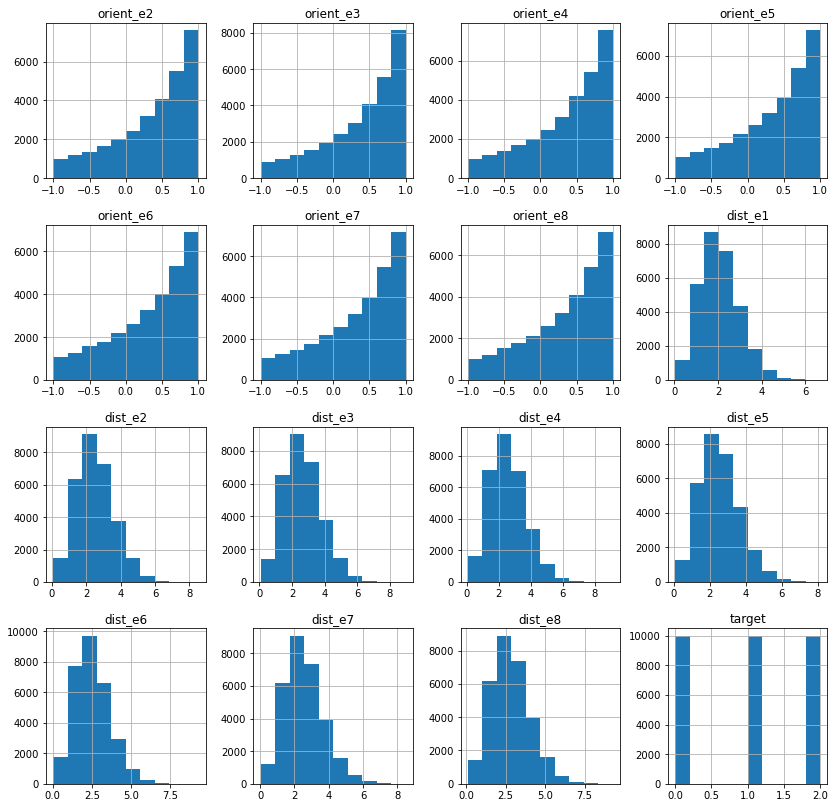

In [15]:
# creating histograms
data.hist(figsize=(14, 14))
plt.show()

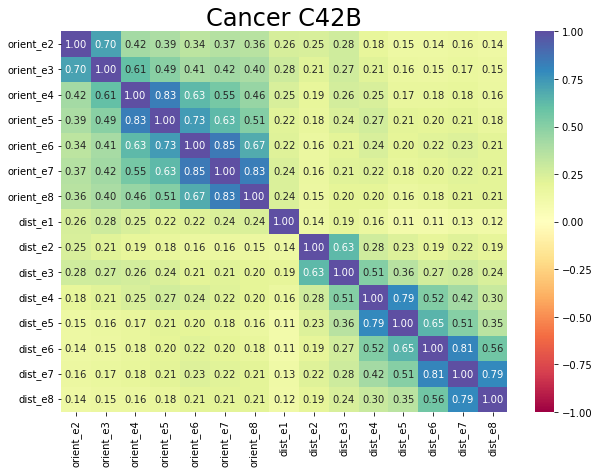

In [38]:
## Normal RWPE1 cell line 
reduced_data = data[data['target'] == 1]
reduced_data.drop(columns='target', inplace = True)
plt.figure(figsize=(10, 7))
sns.heatmap(
    reduced_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.title('Cancer C42B',  fontsize=24)
plt.savefig('corr_c42b.pdf', transparent = False, bbox_inches = 'tight')

plt.show()

In [25]:
reduced_data = data[data['target'] == 0]
reduced_data.drop(columns='target', inplace = True)
reduced_data.head()

,orient_e2,orient_e3,orient_e4,orient_e5,orient_e6,orient_e7,orient_e8,dist_e1,dist_e2,dist_e3,dist_e4,dist_e5,dist_e6,dist_e7,dist_e8
0,0.685435,0.796729,0.907707,0.971096,0.856117,0.720965,0.740984,1.370579,4.809314,4.263870,4.400813,3.735951,3.710420,3.734836,4.294978
1,-0.083142,0.835072,0.965512,0.627489,0.112756,-0.197601,-0.397739,1.140746,4.326655,2.023423,1.710969,1.354947,0.894267,1.164806,1.260783
2,-0.913365,-0.799924,0.585644,0.666694,0.566778,0.188726,0.320616,2.751229,0.972088,1.141908,0.798341,1.595964,1.937399,1.419028,0.873441
3,0.785374,0.531990,0.747982,0.779584,0.705420,0.746550,0.848505,2.001172,3.665906,3.943866,1.715141,2.607063,3.375362,4.437062,4.451699
4,-0.738241,-0.452478,-0.715203,0.173102,0.993157,0.750312,0.331244,1.399851,1.205549,1.695816,0.220676,0.917498,0.598061,2.441693,3.678087


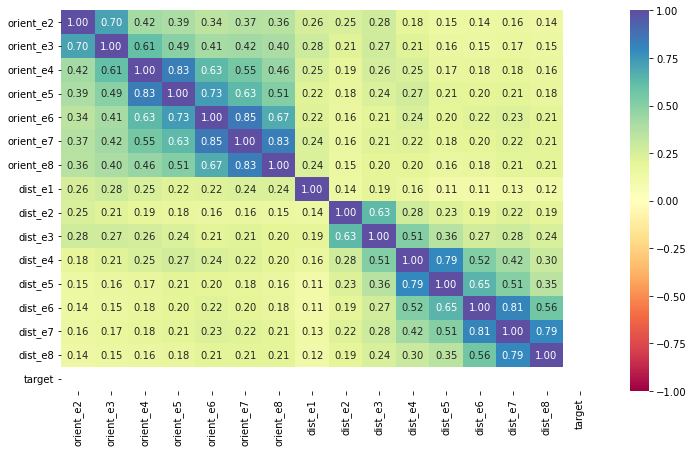

In [157]:
## cancer C42B

plt.figure(figsize=(12, 7))
sns.heatmap(
    data[data['target'] == 1].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

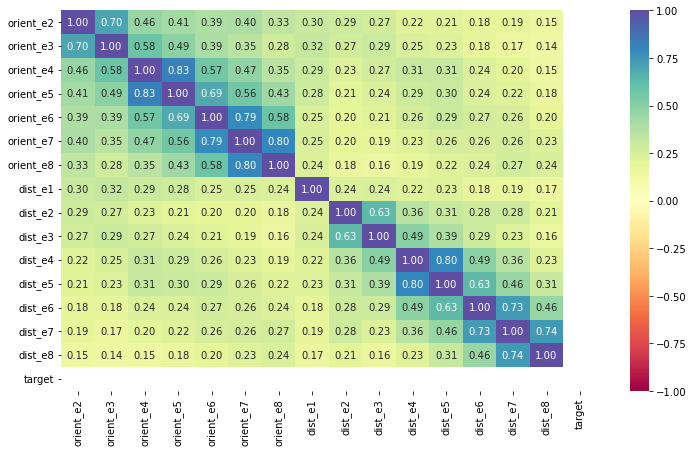

In [158]:
# Cancer 22RV1
plt.figure(figsize=(12, 7))
sns.heatmap(
    data[data['target'] == 2].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

### Observation 

1. The orientation of the enhancers are more correlated in the normal cell line compared to the cancer cell line. 

2. Similar observatiopn has been seen with the distance where the distances of enhancer with the promoter decorrelated in the normal cell line. The distance decorrelates to 0.16 between the two enhancers in the cancer cell line while it only decolretales tp 0.36 in the normal cell line.  

## Building model 

In [39]:
#Separating target variable and other variables
X=data.drop(columns='target')
y=data['target']

In [40]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(18000, 15) (6000, 15) (6000, 15)


In [41]:
X_train.head()

,orient_e2,orient_e3,orient_e4,orient_e5,orient_e6,orient_e7,orient_e8,dist_e1,dist_e2,dist_e3,dist_e4,dist_e5,dist_e6,dist_e7,dist_e8
8737,0.702196,0.957586,0.997702,0.886420,0.466818,0.029737,-0.384473,1.510512,2.866090,2.931675,3.089420,1.008702,0.775184,1.031088,1.605171
3697,-0.411839,-0.137387,0.887110,0.673137,0.643212,0.567000,0.637361,1.213669,1.876633,1.756217,1.966441,1.588712,2.441374,2.445704,1.405826
5425,0.478494,0.651277,0.711327,0.642687,0.895531,0.606193,0.277610,1.256014,1.962873,2.288803,1.887110,0.818618,0.802954,1.453302,0.748697
807,-0.661267,0.101050,0.244293,0.287272,0.564714,0.503627,0.540571,0.913638,1.971775,3.863592,3.723412,3.441951,4.842693,5.532451,7.336111
5604,-0.453067,-0.351282,0.113811,0.282234,0.488772,0.688228,0.538969,1.813716,3.603657,2.454673,3.475557,2.996579,2.524184,2.645865,3.102029


In [42]:
# Check the split data

print("{0:0.2f}% data is in training set".format((len(X_train)/len(data.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(data.index)) * 100))

60.00% data is in training set
20.00% data is in test set


In [43]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [44]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 3)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Building models 

In [45]:
from sklearn.linear_model import LogisticRegression

# fit the model on train 
model = LogisticRegression(solver='newton-cg', multi_class='multinomial', random_state=1)
model.fit(X_train, y_train)

# predict on model 
y_predict = model.predict(X_test)

coef_df = pd.DataFrame(model.coef_)
coef_df['intercept'] = model.intercept_
print(coef_df)



          0         1         2         3         4         5         6  \
0 -0.161883 -0.045259  0.022613 -0.121795 -0.040645 -0.086210  0.186015   
1 -0.123425  0.011927  0.196009 -0.316943 -0.009004  0.052554 -0.071462   
2  0.285308  0.033332 -0.218622  0.438738  0.049649  0.033656 -0.114552   

          7         8         9        10        11        12        13  \
0 -0.282290 -0.000320  0.052861  0.027324  0.008799  0.234282  0.303277   
1  0.179328 -0.076933  0.164322 -0.092481 -0.090320  0.112197 -0.092151   
2  0.102962  0.077253 -0.217182  0.065157  0.081521 -0.346479 -0.211125   

         14  intercept  
0 -0.133134  -0.578785  
1 -0.008743  -0.016324  
2  0.141877   0.595110  


In [46]:
model_score = model.score(X_train, y_train)
print(model_score)

0.48183333333333334


In [47]:
model_score = model.score(X_test, y_test)
print(model_score)

0.4791666666666667


In [48]:
labels = ['rwpe1', 'c42b', '22rv1']

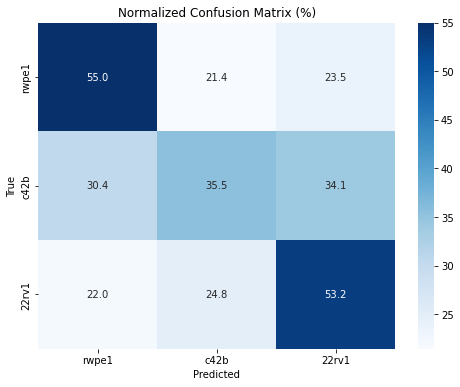

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalization to percentages

# Create a heatmap to visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (%)')
plt.show()


In [50]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


In [51]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(3, 3)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [52]:
# creating confusion matrix
#onfusion_matrix_sklearn_with_threshold(model, X_train, y_train)

### Building other models and checking for higher accuracy 

In [87]:
from sklearn.metrics import recall_score

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="mlogloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

print("\nTraining Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    scores = recall_score(y_train, y_train_pred, average='micro')  # Choose an appropriate averaging strategy
    print("{}: {}".format(name, scores))

print("\nValidation Performance:\n")

for name, model in models:
    y_val_pred = model.predict(X_val)
    scores_val = recall_score(y_val, y_val_pred, average='micro')  # Choose an appropriate averaging strategy
    print("{}: {}".format(name, scores_val))



Training Performance:

Logistic regression: 0.7114444444444444
Bagging: 0.9867222222222222
Random forest: 1.0
GBM: 0.7252222222222222
Adaboost: 0.7142222222222222
Xgboost: 0.8588333333333333
dtree: 1.0

Validation Performance:

Logistic regression: 0.708
Bagging: 0.662
Random forest: 0.7085
GBM: 0.7131666666666666
Adaboost: 0.7088333333333333
Xgboost: 0.6973333333333334
dtree: 0.6131666666666666


## Tuning the XGBoost model 

In [53]:
tuned_xgb2 = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.7,
    n_estimators=150,
    learning_rate=0.05,
    gamma=5,
)



tuned_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [54]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance for multiclass classification.

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    # Predict using the independent variables
    pred = model.predict(predictors)

    # Compute Accuracy
    acc = accuracy_score(target, pred)

    # Compute Recall, Precision, and F1-score for each class
    recall = recall_score(target, pred, average='weighted')
    precision = precision_score(target, pred, average='weighted')
    f1 = f1_score(target, pred, average='weighted')

    # Create a classification report to get per-class metrics
    class_report = classification_report(target, pred, output_dict=True)

    # Creating a dictionary of metrics
    metrics = {
        "Accuracy": acc,
        "Recall (Weighted)": recall,
        "Precision (Weighted)": precision,
        "F1 (Weighted)": f1,
    }

    # Add per-class metrics to the dictionary
    for class_name, class_metrics in class_report.items():
        if class_name.isdigit():  # Check if the class name is a valid integer (class label)
            class_name = int(class_name)
            metrics[f"Recall (Class {class_name})"] = class_metrics['recall']
            metrics[f"Precision (Class {class_name})"] = class_metrics['precision']
            metrics[f"F1 (Class {class_name})"] = class_metrics['f1-score']

    # Create a DataFrame of metrics
    df_perf = pd.DataFrame(metrics, index=[0])

    return df_perf


In [55]:
# Checking model's performance on training set
xgb2_train = model_performance_classification_sklearn(tuned_xgb2, X_train, y_train)
xgb2_train

,Accuracy,Recall (Weighted),Precision (Weighted),F1 (Weighted),Recall (Class 0),Precision (Class 0),F1 (Class 0),Recall (Class 1),Precision (Class 1),F1 (Class 1),Recall (Class 2),Precision (Class 2),F1 (Class 2)
0,0.561,0.561,0.561839,0.557504,0.567167,0.588347,0.577563,0.4475,0.551222,0.493975,0.668333,0.54595,0.600974


In [56]:
## prediction of the validation score 

y_val_pred = tuned_xgb2.predict(X_val)
scores_val = recall_score(y_val, y_val_pred, average='micro')  # Choose an appropriate averaging strategy
print(scores_val)

0.49466666666666664


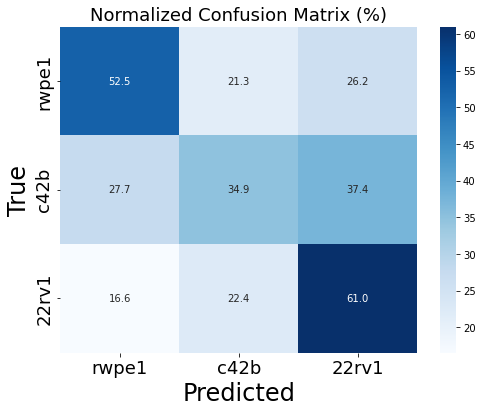

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalization to percentages

# Create a heatmap to visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize = 24)
plt.ylabel('True', fontsize = 24)
plt.tick_params(axis = 'x', labelsize =18)
plt.tick_params(axis = 'y', labelsize =18)
plt.title('Normalized Confusion Matrix (%)', fontsize = 18)
plt.savefig('confusion_matrix_xgboost.pdf', transparent = False, bbox_inches = 'tight')
plt.show()


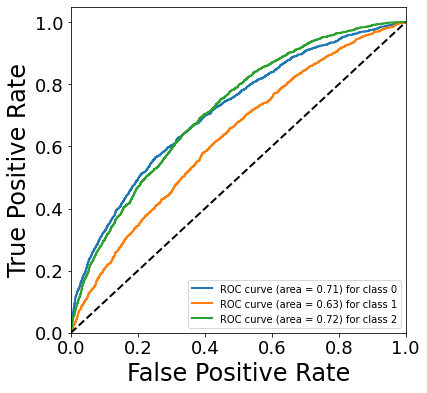

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming you have a model named 'model' and you've already fitted it

# Binarize the labels (one-hot encoding)
y_val_binarized = label_binarize(y_val, classes=range(3))

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Assuming 'model' can predict class probabilities using predict_proba
y_score = tuned_xgb2.predict_proba(X_val)

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(6, 6))

for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize= 24)
plt.ylabel('True Positive Rate', fontsize = 24)
#plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')

plt.tick_params(axis = 'x', labelsize =18)
plt.tick_params(axis = 'y', labelsize =18)
plt.savefig('roc_xgboost.pdf', transparent = False, bbox_inches = 'tight')
plt.show()



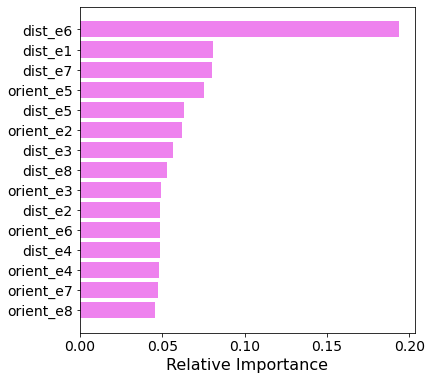

In [82]:
feature_names = X_train.columns
importances = tuned_xgb2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6, 6))
#plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance", fontsize = 16)
plt.tick_params(axis = 'x', labelsize =14)
plt.tick_params(axis = 'y', labelsize =14)
plt.savefig('features_xgboost.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

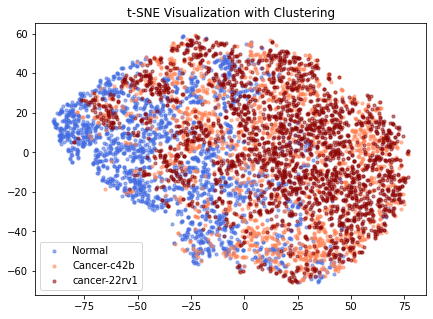

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Assuming you have X_train and y_train

# Step 1: Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_val_tsne = tsne.fit_transform(X_val)

# Step 2: Predict cluster labels using K-Means
#kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = y_val_pred

# Step 3: Plot the t-SNE results with colored clusters
plt.figure(figsize=(7, 5))

# Customize the colors based on the predicted cluster labels
colors = ['royalblue',  'coral', 'darkred']
custom_cluster_names = ['Normal ', 'Cancer-c42b', 'cancer-22rv1']  # Customize cluster names

for i in range(3):
    plt.scatter(
        X_val_tsne[cluster_labels == i, 0],
        X_val_tsne[cluster_labels == i, 1],
        c=colors[i],
        label=custom_cluster_names[i],  # Use custom cluster names
        s=10,      # Adjust the size as needed (smaller size)
        alpha=0.5  # Adjust the transparency as needed (0.0 for fully transparent, 1.0 for fully opaque)
    )

plt.title("t-SNE Visualization with Clustering")
plt.legend()
plt.show()

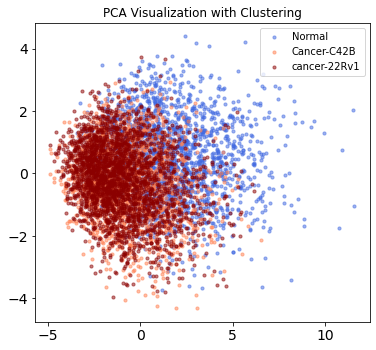

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming you have X_train and y_train

# Step 1: Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_val_pca = pca.fit_transform(X_val)

# Step 2: Predict cluster labels using K-Means
# kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = y_val_pred  # Assuming y_val_pred contains your predicted labels

# Step 3: Plot the PCA results with colored clusters and custom cluster names
plt.figure(figsize=(6, 5.5))

# Customize the colors based on the predicted cluster labels
colors = ['royalblue', 'coral', 'darkred']
custom_cluster_names = ['Normal ', 'Cancer-C42B', 'cancer-22Rv1']  # Customize cluster names

for i in range(3):
    plt.scatter(
        X_val_pca[cluster_labels == i, 0],
        X_val_pca[cluster_labels == i, 1],
        c=colors[i],
        label=custom_cluster_names[i],  # Use custom cluster names
        s=10,      # Adjust the size as needed (smaller size)
        alpha=0.5  # Adjust the transparency as needed (0.0 for fully transparent, 1.0 for fully opaque)
    )
    
plt.title("PCA Visualization with Clustering")
plt.legend()
plt.tick_params(axis = 'x', labelsize =14)
plt.tick_params(axis = 'y', labelsize =14)
plt.savefig('pca_xgboost.pdf', transparent = False, bbox_inches = 'tight')
plt.show()


In [207]:
df = pd.DataFrame(y_val_pred, columns=['pred'])

In [208]:
df['actual'] = y_val.to_numpy()

In [211]:
df.value_counts()

pred  actual
2     2         1220
0     0         1050
2     1          748
1     1          698
0     1          554
2     0          524
1     2          449
      0          426
0     2          331
dtype: int64

In [218]:
df['pred'].value_counts()

2    2492
0    1935
1    1573
Name: pred, dtype: int64

In [219]:
df['actual'].value_counts()

cancer-22rv1    2000
normal-rwpe1    2000
cancer-c42b     2000
Name: actual, dtype: int64

In [215]:
#df['pred'] = df['pred'].replace({1: 'cancer-like', 0: 'normal-like'})
df['actual'] = df['actual'].replace({2: 'cancer-22rv1', 1: 'cancer-c42b', 0: 'normal-rwpe1' })

In [216]:
df.value_counts()

pred  actual      
2     cancer-22rv1    1220
0     normal-rwpe1    1050
2     cancer-c42b      748
1     cancer-c42b      698
0     cancer-c42b      554
2     normal-rwpe1     524
1     cancer-22rv1     449
      normal-rwpe1     426
0     cancer-22rv1     331
dtype: int64

In [217]:
df

,pred,actual
0,2,cancer-22rv1
1,2,cancer-22rv1
2,1,normal-rwpe1
3,0,cancer-c42b
4,0,normal-rwpe1
...,...,...
5995,0,normal-rwpe1
5996,0,normal-rwpe1
5997,0,cancer-c42b
5998,0,cancer-22rv1


In [221]:
df[df['actual']=='cancer-c42b'].value_counts()

pred  actual     
2     cancer-c42b    748
1     cancer-c42b    698
0     cancer-c42b    554
dtype: int64

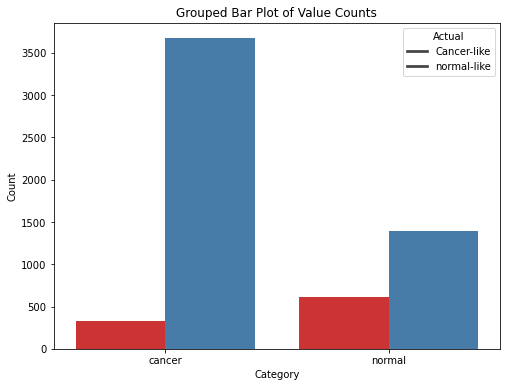

In [202]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the provided data
data = {
    'Category': ['cancer', 'normal', 'normal', 'cancer'],
    'pred': [1, 1, 0, 0],
    'Count': [3674, 1393, 607, 326]
}
df = pd.DataFrame(data)

# Create a grouped bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Category', y='Count', hue='pred', palette='Set1')

# Customize the plot, including labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Grouped Bar Plot of Value Counts')
plt.legend(title='Actual', labels=['Cancer-like', 'normal-like'])

# Show the plot
plt.show()


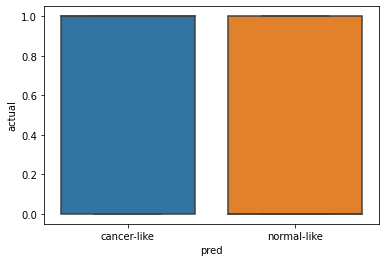

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
sns.boxplot(data=df, x='pred', y='actual')
plt.show()

## Artificial Neural Network model 

In [222]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

NameError: name 'backend' is not defined

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier  # Import XGBClassifier for multiclass classification
import numpy as np
from sklearn import metrics

# Define the XGBClassifier model for multiclass classification
Model = XGBClassifier(random_state=1, eval_metric='mlogloss')  # Use 'mlogloss' for multiclass log loss

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': [0.01, 0.1, 0.2, 0.05],
    'gamma': [0, 1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score, average='micro')  # Use 'f1_micro' for multiclass

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={:.2f}:".format(randomized_cv.best_params_, randomized_cv.best_score_))


In [19]:
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier  # Import GradientBoostingClassifier

# Define your model
model = GradientBoostingClassifier(random_state=1)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Calculate the recall score on the training data (choose an appropriate averaging strategy)
scores = recall_score(y_train, y_train_pred, average='micro')

# Print the recall score
print("Training Recall Score: {:.2f}".format(scores))

# Make predictions on the validation data
y_val_pred = model.predict(X_val)

# Calculate the recall score on the validation data (choose an appropriate averaging strategy)
scores_val = recall_score(y_val, y_val_pred, average='micro')

# Print the recall score for validation data
print("Validation Recall Score: {:.2f}".format(scores_val))



Training Recall Score: 0.54
Validation Recall Score: 0.49


In [ ]:
labels = ['rwpe1', 'c42b', '22rv1']

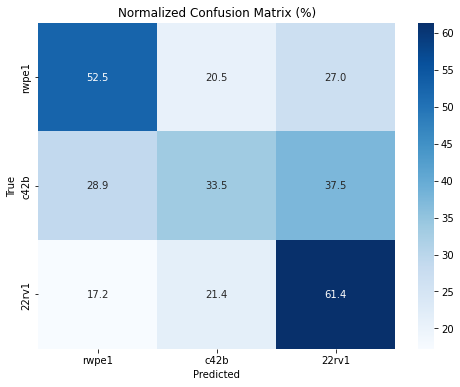

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalization to percentages

# Create a heatmap to visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (%)')
plt.show()


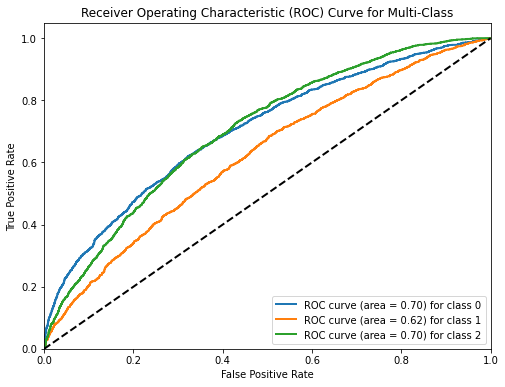

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming you have a model named 'model' and you've already fitted it

# Binarize the labels (one-hot encoding)
y_val_binarized = label_binarize(y_val, classes=range(3))

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Assuming 'model' can predict class probabilities using predict_proba
y_score = model.predict_proba(X_val)

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()


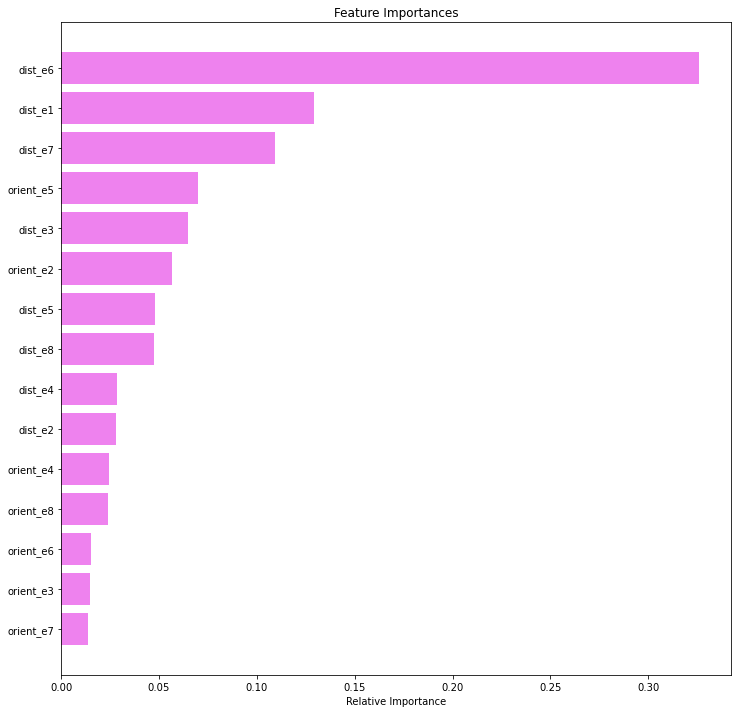

In [27]:
feature_names = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Visualisation in the dimensionally reduced space 

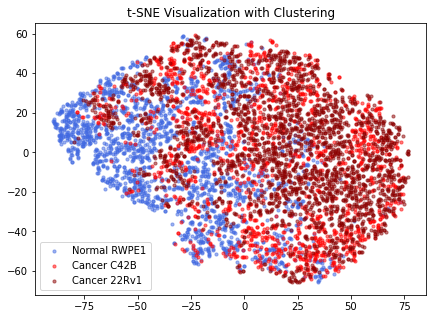

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Assuming you have X_train and y_train

# Step 1: Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_val_tsne = tsne.fit_transform(X_val)

# Step 2: Predict cluster labels using K-Means
#kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = y_val_pred

# Step 3: Plot the t-SNE results with colored clusters
plt.figure(figsize=(7, 5))

# Customize the colors based on the predicted cluster labels
colors = ['royalblue', 'red', 'darkred']
custom_cluster_names = ['Normal RWPE1', 'Cancer C42B', 'Cancer 22Rv1']  # Customize cluster names

for i in range(3):
    plt.scatter(
        X_val_tsne[cluster_labels == i, 0],
        X_val_tsne[cluster_labels == i, 1],
        c=colors[i],
        label=custom_cluster_names[i],  # Use custom cluster names
        s=10,      # Adjust the size as needed (smaller size)
        alpha=0.5  # Adjust the transparency as needed (0.0 for fully transparent, 1.0 for fully opaque)
    )

plt.title("t-SNE Visualization with Clustering")
plt.legend()
plt.show()

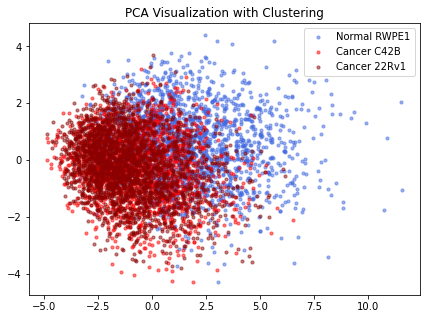

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming you have X_train and y_train

# Step 1: Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_val_pca = pca.fit_transform(X_val)

# Step 2: Predict cluster labels using K-Means
# kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = y_val_pred  # Assuming y_val_pred contains your predicted labels

# Step 3: Plot the PCA results with colored clusters and custom cluster names
plt.figure(figsize=(7, 5))

# Customize the colors based on the predicted cluster labels
colors = ['royalblue', 'red', 'darkred']
custom_cluster_names = ['Normal RWPE1', 'Cancer C42B', 'Cancer 22Rv1']  # Customize cluster names

for i in range(3):
    plt.scatter(
        X_val_pca[cluster_labels == i, 0],
        X_val_pca[cluster_labels == i, 1],
        c=colors[i],
        label=custom_cluster_names[i],  # Use custom cluster names
        s=10,      # Adjust the size as needed (smaller size)
        alpha=0.5  # Adjust the transparency as needed (0.0 for fully transparent, 1.0 for fully opaque)
    )

plt.title("PCA Visualization with Clustering")
plt.legend()
plt.show()


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans

# Assuming you have X_train and y_train

# Step 1: Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
X_val_umap = umap_model.fit_transform(X_val)

# Step 2: Predict cluster labels using K-Means
# kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = y_val_pred  # Assuming y_val_pred contains your predicted labels

# Step 3: Plot the UMAP results with colored clusters and custom cluster names
plt.figure(figsize=(7, 5))

# Customize the colors based on the predicted cluster labels
colors = ['royalblue', 'red', 'darkred']
custom_cluster_names = ['Normal RWPE1', 'Cancer C42B', 'Cancer 22Rv1']  # Customize cluster names

for i in range(3):
    plt.scatter(
        X_val_umap[cluster_labels == i, 0],
        X_val_umap[cluster_labels == i, 1],
        c=colors[i],
        label=custom_cluster_names[i],  # Use custom cluster names
        s=10,      # Adjust the size as needed (smaller size)
        alpha=0.5  # Adjust the transparency as needed (0.0 for fully transparent, 1.0 for fully opaque)
    )

plt.title("UMAP Visualization with Clustering")
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'umap'

In [71]:
pip install pacmap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 KB 10.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 16.2 MB/s eta 0:00:0000:0100:01
  Created wheel for annoy: filename=annoy-1.17.3-cp38-cp38-macosx_10_12_x86_64.whl size=73772 sha256=bbcafceb997663e57b4f9c0bff7fd44b0046dcaa4518ef1f497353034ddcedba
  Stored in directory: /Users/kirankumari/Library/Caches/pip/wheels/55/2b/62/d6b83c564671d3cea4eb393ffdfc3ed9b9f2482fc79e8b4c35
Successfully built annoy
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Note: you may need to restart the kernel to use updated packages.


In [75]:
conda install llvmlite


done
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/osx-64::imageio==2.6.1=py38_0
  - conda-forge/osx-64::pyerfa==2.0.0.1=py38hbe852b5_1
  - conda-forge/osx-64::matplotlib-base==3.5.1=py38hc7d2367_0
  - defaults/osx-64::libwebp==1.2.2=h56c3ce4_0
  - conda-forge/osx-64::nbconvert==6.4.4=py38h50d1736_0
  - defaults/osx-64::pillow==9.0.1=py38hde71d04_0
  - conda-forge/noarch::notebook-shim==0.1.0=pyhd8ed1ab_0
  - conda-forge/osx-64::mkl_random==1.2.2=py38h1f261ad_0
  - conda-forge/osx-64::lcms2==2.12=h577c468_0
  - conda-forge/noarch::jinja2-time==0.2.0=pyhd8ed1ab_3
  - conda-forge/noarch::patsy==0.5.2=pyhd8ed1ab_0
  - conda-forge/noarch::sphinxcontrib-websupport==1.2.4=pyhd8ed1ab_1
  - conda-forge/osx-64::astropy==5.0.2=py38h4221b65_0
  - conda-forge/noarch::sphinx==4.4.0=pyh6c4a22f_1
  - conda-forge/noarch::flask==1.1.2=pyh9f0ad1d_0
  - defaults/osx-64::scikit-learn==